In [10]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [13]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [14]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [15]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    pyplot.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        pyplot.hist(longX[:, i], bins=100)
    pyplot.show()

(470528, 9)


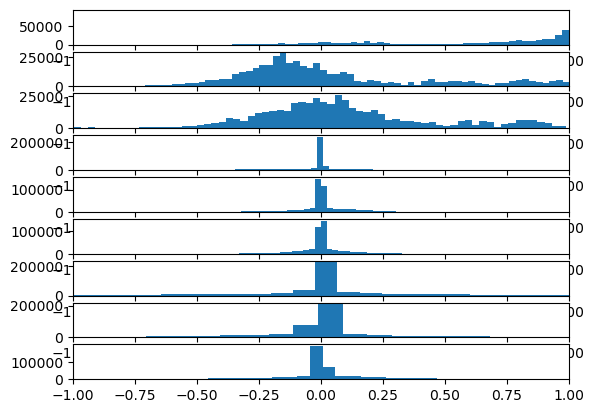

In [16]:
# plot distributions
plot_distributions(trainX)

In [17]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [18]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 10s 95ms/step - loss: 1.2405 - accuracy: 0.4732 - val_loss: 1.1394 - val_accuracy: 0.4616
Epoch 2/10
92/92 [==============================] - 8s 89ms/step - loss: 1.0022 - accuracy: 0.5744 - val_loss: 1.0150 - val_accuracy: 0.5901
Epoch 3/10
92/92 [==============================] - 8s 86ms/step - loss: 0.7549 - accuracy: 0.6791 - val_loss: 0.8258 - val_accuracy: 0.7118
Epoch 4/10
92/92 [==============================] - 8s 89ms/step - loss: 0.6248 - accuracy: 0.7385 - val_loss: 0.7330 - val_accuracy: 0.7859
Epoch 5/10
92/92 [==============================] - 8s 89ms/step - loss: 0.5302 - accuracy: 0.7988 - val_loss: 0.7371 - val_accuracy: 0.7831
Epoch 6/10
92/92 [==============================] - 8s 87ms/step - loss: 0.6885 - accuracy: 0.7354 - val_loss: 0.6022 - val_accuracy: 0.8409
Epoch 7/10
92/92 [==============================] - 8s 89ms/step - loss: 0.3654 - accuracy: 0.8730 - val_loss: 0.4355 - val_accuracy: 0.8742
Epoch 8/10
9

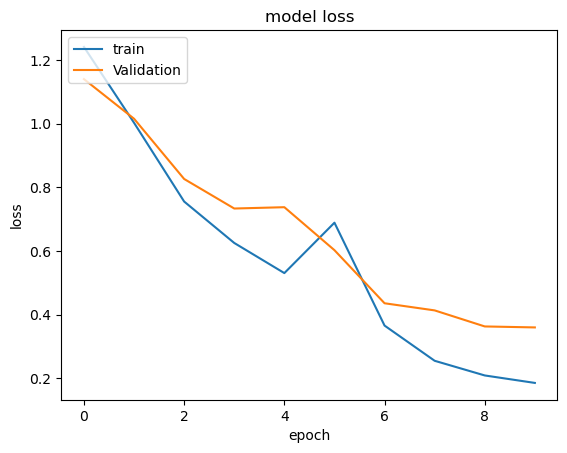

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [22]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8625721335411072
93/93 [==============================] - 2s 24ms/step


In [23]:
predictions

array([[2.3769124e-03, 4.8978237e-04, 3.6479230e-04, 1.4743961e-02,
        9.8198259e-01, 4.1878302e-05],
       [1.7042937e-03, 3.9291664e-04, 2.8404201e-04, 1.5705856e-02,
        9.8187584e-01, 3.7129375e-05],
       [1.6526292e-03, 3.5344053e-04, 2.5321133e-04, 1.4772835e-02,
        9.8293543e-01, 3.2501925e-05],
       ...,
       [1.5745990e-02, 9.7453779e-01, 9.4906501e-03, 2.1593070e-05,
        1.8003916e-04, 2.3966264e-05],
       [1.4913551e-02, 9.7848469e-01, 6.1409492e-03, 3.3882279e-05,
        3.5411862e-04, 7.2754759e-05],
       [1.0447108e-02, 9.8201376e-01, 6.1960383e-03, 6.2478714e-05,
        9.2227588e-04, 3.5827133e-04]], dtype=float32)

In [24]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[458  10  28   0   0   0]
 [ 32 409  30   0   0   0]
 [ 49  24 344   0   3   0]
 [  0   9   0 361 121   0]
 [  6   1   0  49 476   0]
 [  0  27   0  16   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.84      0.92      0.88       496
           2       0.85      0.87      0.86       471
           3       0.86      0.82      0.84       420
           4       0.85      0.74      0.79       491
           5       0.79      0.89      0.84       532
           6       1.00      0.92      0.96       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.87      0.86      0.86      2947



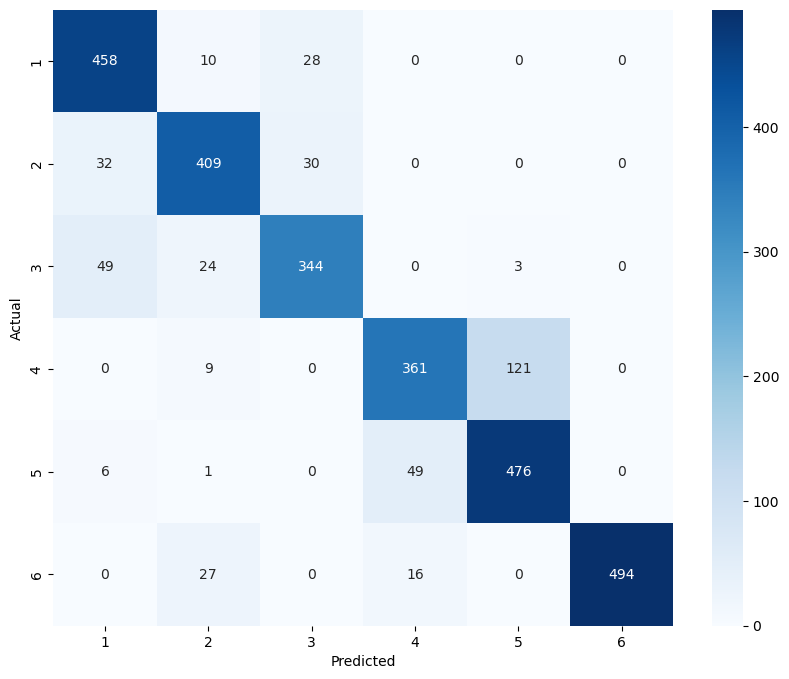

In [25]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [26]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 1s 12ms/step - loss: 0.4971 - accuracy: 0.8055 - val_loss: 0.4282 - val_accuracy: 0.8939
Epoch 2/10
92/92 [==============================] - 1s 11ms/step - loss: 0.1470 - accuracy: 0.9405 - val_loss: 0.3627 - val_accuracy: 0.9055
Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 0.1080 - accuracy: 0.9537 - val_loss: 0.4276 - val_accuracy: 0.9048
Epoch 4/10
92/92 [==============================] - 2s 17ms/step - loss: 0.0937 - accuracy: 0.9595 - val_loss: 0.4284 - val_accuracy: 0.9150
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.0852 - accuracy: 0.9624 - val_loss: 0.4622 - val_accuracy: 0.9109
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.0808 - accuracy: 0.9624 - val_loss: 0.5318 - val_accuracy: 0.9021
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.0761 - accuracy: 0.9651 - val_loss: 0.5823 - val_accuracy: 0.9150
Epoch 8/10
92

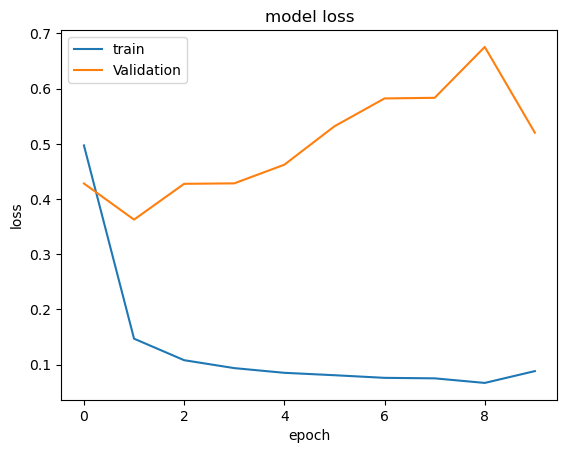

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [30]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9077027440071106
93/93 [==============================] - 0s 2ms/step


**** Confusion Matrix ****
[[462   4  30   0   0   0]
 [ 22 428  21   0   0   0]
 [  8   0 412   0   0   0]
 [  0  24   0 414  53   0]
 [  1   6   0  76 449   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.94      0.93      0.93       496
           2       0.88      0.91      0.89       471
           3       0.89      0.98      0.93       420
           4       0.84      0.84      0.84       491
           5       0.89      0.84      0.87       532
           6       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



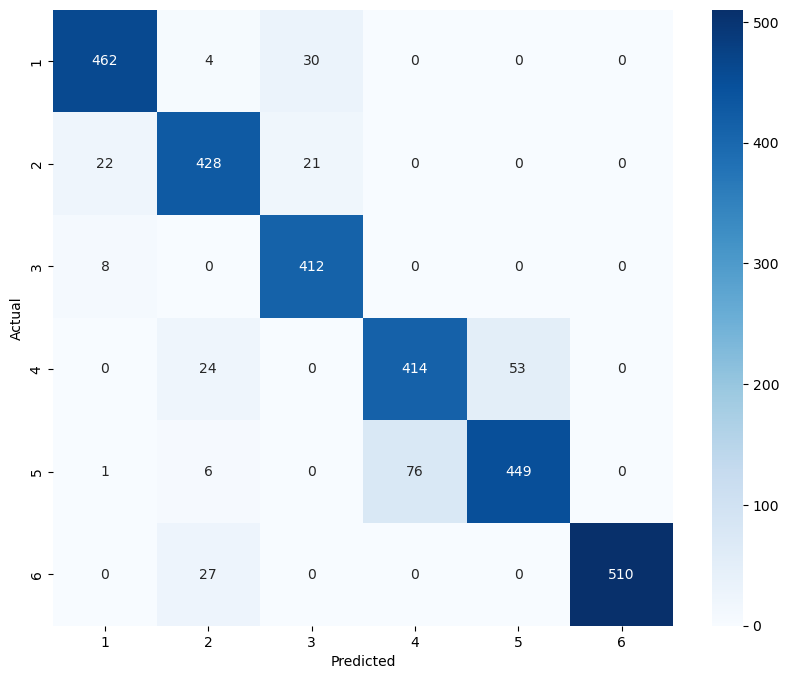

In [31]:
display_results(testy,predictions,classNames)

In [32]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [33]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 11ms/step


In [34]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))  # LSTM layer with return_sequences=True for CNN-LSTM
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

plot_model(model, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 7s 66ms/step - loss: 0.4665 - accuracy: 0.8114 - val_loss: 0.3417 - val_accuracy: 0.8926
Epoch 2/10
92/92 [==============================] - 6s 61ms/step - loss: 0.1365 - accuracy: 0.9415 - val_loss: 0.3182 - val_accuracy: 0.9109
Epoch 3/10
92/92 [==============================] - 6s 64ms/step - loss: 0.1079 - accuracy: 0.9561 - val_loss: 0.3002 - val_accuracy: 0.9130
Epoch 4/10
92/92 [==============================] - 6s 62ms/step - loss: 0.1041 - accuracy: 0.9565 - val_loss: 0.3171 - val_accuracy: 0.9157
Epoch 5/10
92/92 [==============================] - 6s 64ms/step - loss: 0.0925 - accuracy: 0.9599 - val_loss: 0.2842 - val_accuracy: 0.9116
Epoch 6/10
92/92 [==============================] - 6s 62ms/step - loss: 0.0918 - accuracy: 0.9582 - val_loss: 0.3854 - val_accuracy: 0.9041
Epoch 7/10
92/92 [==============================] - 5s 59ms/step - loss: 0.1103 - accuracy: 0.9534 - val_loss: 0.3167 - val_accuracy: 0.9116
Epoch 8/10
92

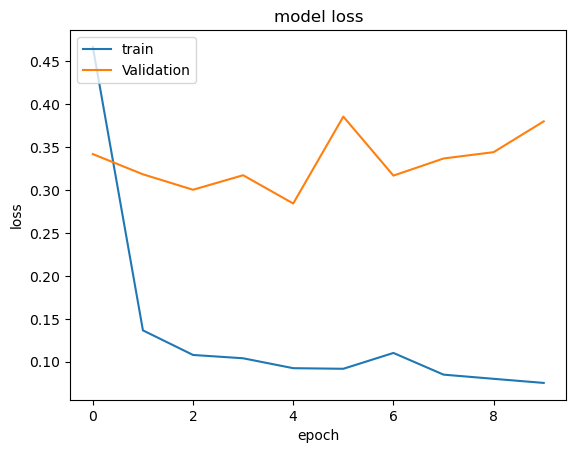

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [39]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN-LSTM model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN-LSTM model 0.9121140241622925
93/93 [==============================] - 1s 10ms/step


**** Confusion Matrix ****
[[464   3  29   0   0   0]
 [  0 447  24   0   0   0]
 [  1   2 417   0   0   0]
 [  1  22   0 378  87   3]
 [  1   2   0  57 472   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.94      0.96       496
           2       0.89      0.95      0.92       471
           3       0.89      0.99      0.94       420
           4       0.87      0.77      0.82       491
           5       0.84      0.89      0.87       532
           6       0.99      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



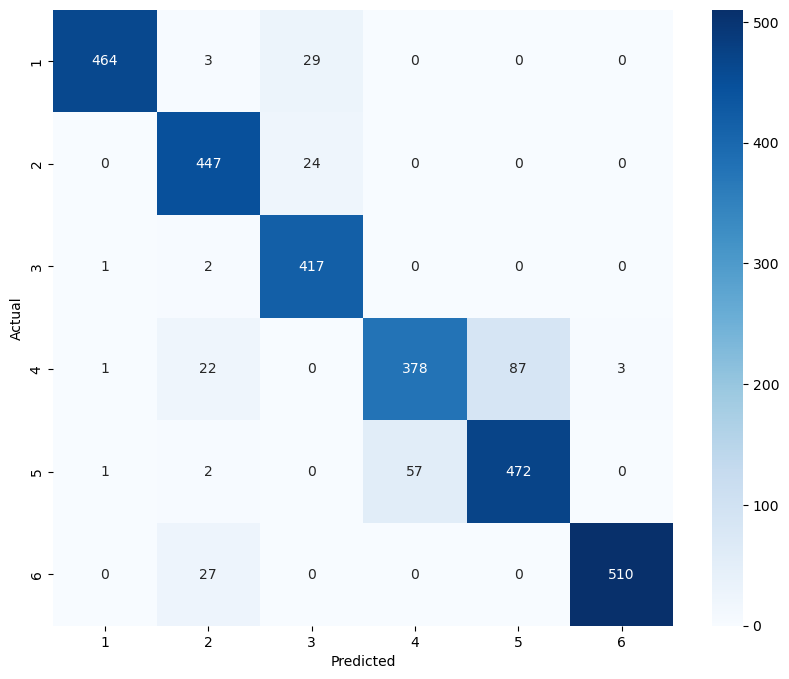

In [40]:
display_results(testy,predictions,classNames)